In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

###Import required libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai import *
from pathlib import Path
from fastai.metrics import error_rate # 1 - accuracy

In [5]:
# !unzip "cgiar.zip" -d ./

In [3]:
import os
# print(os.listdir("./color"))
print(os.listdir("./cgiar"))

['healthy', 'diseased']


In [4]:
###### Set the path
path= Path('./')
# path.ls()
path_train = path/'cgiar'

In [5]:
np.random.seed(8)
# bs = 64
bs = 16
tfms = get_transforms(flip_vert=True, max_warp=0)

data = ImageDataBunch.from_folder(path_train, 
                                  valid_pct=0.2,
                                  train=".",
#                                   test="./test",
                                  ds_tfms=tfms,
                                  size=224,bs=bs, 
                                  num_workers=0).normalize(imagenet_stats)

In [16]:
print(data.classes)
print(len(data.train_ds), len(data.valid_ds))
len(data.classes),data.c

['diseased', 'healthy']
336 83


(2, 2)

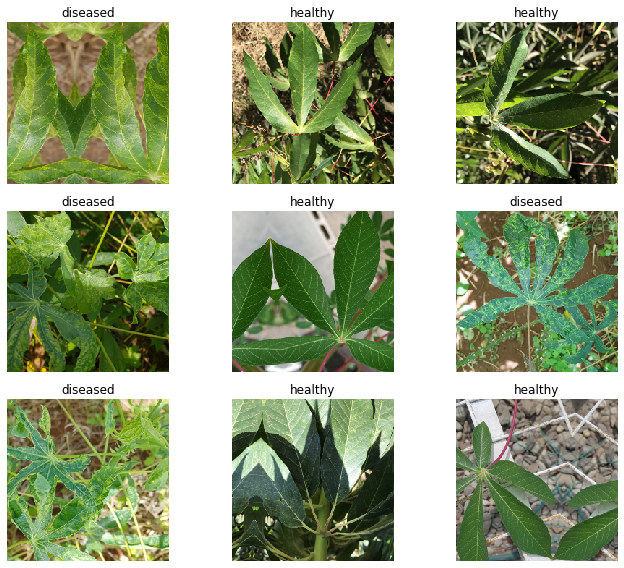

In [20]:
data.show_batch(rows=3, figsize=(10,8))

In [30]:
arch = models.resnet50
# learn = create_cnn(data, arch)
# learn = cnn_learner(data, arch, metrics=error_rate)
learn = cnn_learner(data, arch, metrics=accuracy)

In [31]:
# defaults.device = torch.device('cuda') # makes sure the gpu is used
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.388155,0.162656,0.963855,02:28
1,0.347985,0.061378,0.987952,02:28
2,0.291981,0.070219,0.975904,02:28
3,0.210260,0.067001,0.975904,02:27


In [32]:
learn.export('../cgiar/ciat_image_model_419.pkl')

In [35]:
path = learn.path
path

PosixPath('cgiar')

In [40]:
# learn.save('stage-1')
# learn.export()
# learn.load('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


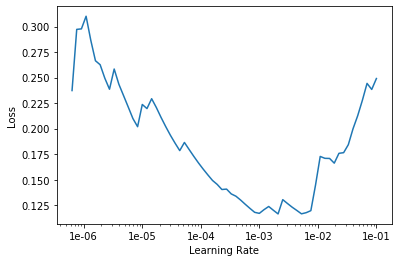

In [38]:
# # learn.unfreeze() # must be done before calling lr_find
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.740202,9.677209,0.722892,02:32
1,0.408233,0.213500,0.951807,02:30
2,0.368267,0.034333,0.987952,02:30


In [43]:
!ls -lh cgiar/

total 295M
-rw-rw-r-- 1 smutuvi smutuvi  99M Jan 20 08:42 ciat_image_model_419_final.pkl
-rw-rw-r-- 1 smutuvi smutuvi  99M Jan 20 08:16 ciat_image_model_419.pkl
drwxr-xr-x 2 smutuvi smutuvi  12K Jan 20  2020 diseased
-rw-rw-r-- 1 smutuvi smutuvi  99M Jan 20 08:20 export.pkl
drwxr-xr-x 2 smutuvi smutuvi  12K Jan 20  2020 healthy
drwxrwxr-x 2 smutuvi smutuvi 4.0K Jan 20 08:21 models


In [42]:
learn.export('../cgiar/ciat_image_model_419_final.pkl')

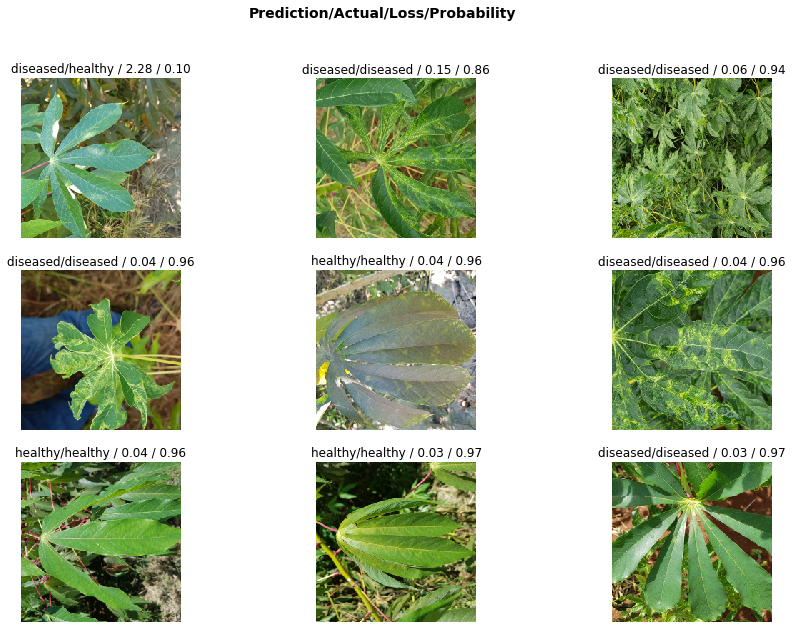

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
# losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15, 10))

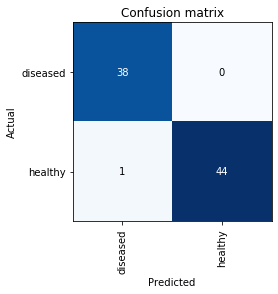

In [45]:
interp.plot_confusion_matrix()

In [21]:
# !unzip test_images.zip

Archive:  test_images.zip
   creating: test_images/
  inflating: test_images/diseased_1.jpg  
  inflating: test_images/diseased_2.jpg  
  inflating: test_images/healthy_1.jpg  
  inflating: test_images/healthy_2.jpg  


In [53]:
learn = load_learner(path='.', file='cgiar/ciat_image_model_419_final.pkl', test=ImageList.from_folder('./test_images'))
# classes = learn.data.classes

In [47]:
dataframes = []
# path = "./"
# directory = "test"

# for directory in ('test'):
#     test = ImageItemList.from_folder(path/directory)
#     learn = load_learner('data', test=test)
# learn = load_learner('cgiar', test=ImageList.from_folder('./test_images'))
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = [f.name[:-4] for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
dataframes.append(df)
    
    
df = pd.concat(dataframes)
# df.to_csv(path/'submission.csv', index=False)
print(df.head())

   image_name      tags
0   healthy_1   healthy
1  diseased_1  diseased
2  diseased_2  diseased
3   healthy_2   healthy


In [60]:
%%writefile ciat_image_classification.py

from bentoml import BentoService, api, env, artifacts
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import FastaiImageHandler
from pathlib import Path

@env(pip_dependencies=['fastai'])
@artifacts([FastaiModelArtifact('ciat_image_classifer')])
class CiatImageClassification(BentoService):
    def get_raw_content(self, raw_directory):
        return [raw_file for raw_file in os.listdir(raw_directory) if os.path.isfile(os.path.join(raw_directory, raw_file))]

    @api(FastaiImageHandler)
    def predict(self, image):
        result = self.artifacts.ciat_image_classifer.predict(image)
        return str(result)
    @api(FastaiImageHandler)
    def predict_batch(self, test_data_dir):
        result = self.artifacts.ciat_image_classifer.predict(test_data_dir)
        return str(result)
#         test_data_dir = 'test_images/'
#         data_files = self.get_raw_content(test_data_dir)
#         for img_file in data_files:
#             result = self.artifacts.ciat_image_classifer.predict(os.path.join(Path(test_data_dir), img_file))
#             return str(result)

Writing ciat_image_classification.py


In [64]:
# !rm -R /home/smutuvi/bentoml/repository/CiatImageClassification/
# !ls /home/smutuvi/bentoml/repository/

CiatImageClassification


In [63]:
#import the custom BentoService defined above
from ciat_image_classification import CiatImageClassification

#pack` it with required artifacts
service = CiatImageClassification.pack(ciat_image_classifer=learn)

#save your BentoSerivce
saved_path = service.save()

[2020-01-20 09:22:22,437] INFO - BentoService bundle 'CiatImageClassification:20200120092205_D9D5AB' created at: /tmp/bentoml-temp-407f3j_c
[2020-01-20 09:22:22,673] INFO - BentoService bundle 'CiatImageClassification:20200120092205_D9D5AB' created at: /home/smutuvi/bentoml/repository/CiatImageClassification/20200120092205_D9D5AB


In [20]:
from bentoml import load

service = load(saved_path)

print(service.predict(data.get(0)))

[2020-01-02 12:26:26,312] WARNING - Module `ciat_image_classification` already loaded, using existing imported module.


TypeError: expected str, bytes or os.PathLike object, not CiatImageClassification

In [33]:
!pip install {saved_path}

Processing ./bentoml/repository/CiatImageClassification/20200102123714_C5CE15
  Created wheel for CiatImageClassification: filename=CiatImageClassification-20200102123714_C5CE15-cp36-none-any.whl size=95424720 sha256=56428b97b53fded8c8836ae11516d6c95224afe2daec4ef54fe6b832b452aea5
  Stored in directory: /tmp/pip-ephem-wheel-cache-rztsc0te/wheels/72/41/66/21c8233e4ac7704c19a5635c668acc780bcf63f62f66a249e4
Successfully built CiatImageClassification
  Found existing installation: CiatImageClassification 20200102122044b3540
    Uninstalling CiatImageClassification-20200102122044b3540:
      Successfully uninstalled CiatImageClassification-20200102122044b3540


In [38]:
# # !wget https://www.pragueresident.com/wp-content/uploads/2019/08/dog-1.jpeg
# !CiatImageClassification predict --input=dog-1.jpeg

(Category diseased, tensor(0), tensor([9.9988e-01, 1.2068e-04]))


In [22]:
!bentoml serve {saved_path}

 * Serving Flask app "CiatImageClassification" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [02/Jan/2020 12:30:40] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jan/2020 12:30:41] "GET /static/swagger-ui.css HTTP/1.1" 200 -
127.0.0.1 - - [02/Jan/2020 12:30:41] "GET /static/swagger-ui-bundle.js HTTP/1.1" 200 -
127.0.0.1 - - [02/Jan/2020 12:30:43] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [02/Jan/2020 12:30:43] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [02/Jan/2020 12:30:50] "GET /predict HTTP/1.1" 405 -
127.0.0.1 - - [02/Jan/2020 12:30:55] "GET /predict_batch HTTP/1.1" 404 -
127.0.0.1 - - [02/Jan/2020 12:32:14] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [02/Jan/2020 12:32:46] "POST /predict_batch HTTP/1.1" 404 -
127.0.0.1 - - [02/Jan/2020 12:33:11] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [02/Jan/2020 12:33:26] "POST /predict_batch HTTP/1.1" 404 -
1

In [41]:
!curl -i \
    --request POST \
    --header "Content-Type: multipart/form-data" \
    -F "image=@dog-1.jpeg" \
    localhost:5000/predict

curl: (7) Failed to connect to localhost port 5000: Connection refused
